# Matrix Factorization For Recommendation Systems: A Comparative Study Using MyAnimeList Data

## Data Pre-processing

In [1]:
# Imports and process data
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import sklearn
import matplotlib.pyplot as plt

user_rating_raw = './datasets/user_rating_data.csv'
df = pd.read_csv(user_rating_raw)
user_rating_df = df[['user_id', 'mal_id', 'rating', 'title']].copy()

#### Filter dataset by anime titles with at least a total count of 1000 ratings and users with at least at total count of 750 ratings
This is to ensure that our data uses animes and users that have enough data to make efficient models.

In [2]:
total_ratings = (user_rating_df.groupby(by = ['title'])['rating'].
                count().
                reset_index().
                rename(columns = {'rating' : 'totalRatingCount'})
                [['title', 'totalRatingCount']]
                )
print(total_ratings.shape[0], "anime titles in original dataset.")

6598 anime titles in original dataset.


In [3]:
userRatings_with_totalRatings = user_rating_df.merge(total_ratings, left_on='title', right_on='title')

popularity_threshold = 1000 # this can be changed to narrow the scope of our data
ratings_top_anime = userRatings_with_totalRatings.query('totalRatingCount >= @popularity_threshold')
n = len(pd.unique(ratings_top_anime['title']))
print(n, "unique anime titles to be used for analysis.")

3043 unique anime titles to be used for analysis.


In [4]:
user_total_ratings = (ratings_top_anime.groupby(by = ['user_id'])['rating'].
                count().
                reset_index().
                rename(columns = {'rating' : 'userTotalRatingCount'})
                [['user_id', 'userTotalRatingCount']]
                )
print(user_total_ratings.shape[0], "users who have rated anime titles that have over 1000 total rating count.")

106363 users who have rated anime titles that have over 1000 total rating count.


In [5]:
userTotalRatings_threshold = 750 # this can be changed to narrow the scope of our data
ratings_top_user_anime = user_total_ratings.query('userTotalRatingCount >= @userTotalRatings_threshold')
n = len(pd.unique(ratings_top_user_anime['user_id']))
print(n, "unique users to be used for analysis.")

2124 unique users to be used for analysis.


#### Dataset

The final dataset will include the 3043 unique anime titles that have a sufficient total number of ratings and 2124 unique users who have rated good amount of anime.  

In [6]:
# Filter out users who haven't rated enough anime
filtered_ratings_top_anime = ratings_top_anime.merge(ratings_top_user_anime, left_on='user_id', right_on='user_id')
user_anime_ratings = filtered_ratings_top_anime.drop(['totalRatingCount', 'userTotalRatingCount'], axis=1)
user_item_ratings = user_anime_ratings.drop(columns='title')
user_anime_ratings

,user_id,mal_id,rating,title
0,101,1364,7,Detective Conan Movie 05: Countdown to Heaven
1,101,3420,7,Shigofumi
2,101,2251,9,Baccano!
3,101,1818,8,Claymore
4,101,245,9,Great Teacher Onizuka
...,...,...,...,...
2119511,44110,18177,7,Yowamushi Pedal: Special Ride
2119512,44110,34565,5,Jikan no Shihaisha
2119513,44110,31994,6,Yami Shibai 3
2119514,44110,34262,8,Oushitsu Kyoushi Heine


### Matrix For Testing Models

This final matrix will be used as the data input of our matrix factorization class to test the three different recommendation models: SVD, ALS and SGD.

In [7]:
user_anime_ratings_matrix = filtered_ratings_top_anime.pivot_table(index = 'user_id', columns='title', values='rating', aggfunc=np.sum).fillna(0)
user_anime_ratings_matrix

title,"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi","""Bungaku Shoujo"" Memoire","""Bungaku Shoujo"" Movie",.hack//G.U. Returner,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,.hack//Roots,.hack//Sign,...,ef: A Tale of Melodies. - Prologue,ef: A Tale of Memories.,ef: A Tale of Memories. - Prologue,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Shunmuki,ēlDLIVE
user_id,,,,,,,,,,,,,,,,,,,,,
14,9.0,9.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,6.0,6.0,6.0,6.0,7.0,7.0,7.0,...,0.0,8.0,0.0,0.0,0.0,8.0,8.0,8.0,8.0,6.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,8.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,9.0,8.0,0.0,0.0,8.0,9.0,8.0,8.0,0.0
58,6.0,0.0,0.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,...,7.0,8.0,7.0,0.0,6.0,0.0,0.0,7.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,6.0,0.0,0.0,0.0,6.0,6.0,0.0,0.0,0.0
106213,7.0,7.0,8.0,7.0,6.0,6.0,0.0,7.0,0.0,7.0,...,7.0,8.0,0.0,6.0,0.0,8.0,8.0,8.0,8.0,0.0
106234,0.0,9.0,8.0,8.0,8.0,8.0,8.0,9.0,7.0,7.0,...,8.0,9.0,8.0,0.0,8.0,9.0,9.0,8.0,9.0,0.0


## Data Information

In [8]:
n_users = user_anime_ratings.user_id.unique().shape[0]
n_items = user_anime_ratings.mal_id.unique().shape[0]
inputMatrix = user_anime_ratings_matrix.values # inputMatrix matrix where users are rows

print(str(n_users) + ' users')
print(str(n_items) + ' items')
sparsity = float(len(inputMatrix.nonzero()[0]))
sparsity /= (inputMatrix.shape[0] * inputMatrix.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

2124 users
3043 items
Sparsity: 32.79%


# Matrix Factorization: Class & Evaluation Methods

Code for ALS & SGD adapted from: https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea  
Code for SVD adapted from: https://towardsdatascience.com/beginners-guide-to-creating-an-svd-recommender-system-1fd7326d1f65

### Class for Evaluating the Different MF Models

In [9]:
import math
import numpy.ma as ma
from numpy.linalg import solve
from scipy.linalg import sqrtm

from sklearn.metrics import mean_squared_error

class ExplicitMF():
    def __init__(self, 
                 inputMatrix,
                 n_factors=40,
                 learning='SGD',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes an
        input ratings matrix which is ~ user x item
        
        Params
        ======
        inputMatrix : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'SVD, SGD' or 'ALS'.
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.inputMatrix = inputMatrix
        self.n_users, self.n_items = inputMatrix.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        self._v = verbose
        self.sample_row, self.sample_col = self.inputMatrix.nonzero()
        self.n_samples = len(self.sample_row)
        
    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 inputMatrix,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             inputMatrix[u, :].dot(fixed_vecs))
        if type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             inputMatrix[:, i].T.dot(fixed_vecs))
        return latent_vectors
    
    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.inputMatrix[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            # Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])

    def svd(self):
        
        utilMat = self.inputMatrix.copy()
        k = self.n_factors

        # the nan or unavailable entries are masked
        masked_arr = np.ma.masked_equal(utilMat,0)
        item_means = np.mean(masked_arr, axis=0)

        # nan entries will replaced by the average rating for each item
        utilMat = masked_arr.filled(item_means)
        x = np.tile(item_means, (utilMat.shape[0],1))

        # we remove the per item average from all entries.
        # the above mentioned nan entries will be essentially zero now
        utilMat = utilMat - x

        # Run numpy SVD. U and V are user and item features
        U, s, V=np.linalg.svd(self.inputMatrix)
        self.user_vecs = U
        self.item_vecs = V
        
        U, s, V=np.linalg.svd(utilMat, full_matrices=False)
        s=np.diag(s)

        # Take only the k most significant features
        s=s[0:k,0:k]
        U=U[:,0:k]
        V=V[0:k,:]

        s_root=sqrtm(s)

        Usk=np.dot(U,s_root)
        skV=np.dot(s_root,V)
        UsV = np.dot(Usk, skV)

        UsV = UsV + x
        # Returns matrix with predicted values
        return UsV
    
    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        
        if self.learning == 'ALS':
            self.partial_train(n_iter)
        elif self.learning == 'SVD':
            self.svd()
        else:
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.inputMatrix[np.where(self.inputMatrix != 0)])
            self.partial_train(n_iter)
            
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration: {}'.format(ctr))
            if self.learning == 'ALS':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.inputMatrix, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.inputMatrix, 
                                               self.item_fact_reg, 
                                               type='item')
            else:
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'ALS':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        else:
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def get_rmse(self, predictions, actual):
        """ Helper function to get RMSE."""
        if self.learning == 'SVD':
            y_true = []
            y_pred = []

            # Change values for 10 predicted ratings in pred
            for u in range(len(actual)):
                for i in range(len(actual[u])):
                    #print(test[u][i])
                    if actual[u][i] != 0.0:
                        #print("not 0")
                        true = actual[u][i]
                        pred = predictions[u][i]
                        y_true.append(true)
                        y_pred.append(pred)
            return math.sqrt(mean_squared_error(y_true, y_pred))
        else:
            # Ignore nonzero terms.
            predictions = predictions[actual.nonzero()].flatten()
            actual = actual[actual.nonzero()].flatten()
            return math.sqrt(mean_squared_error(actual, predictions))
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        """
        Keep track of RMSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_rmse : (list)
            Training data RMSE values for each value of iter_array
        test_rmse : (list)
            Test data RMSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_rmse =[]
        self.test_rmse = []
        
        # TODO in future: create a thorough iterative svd
        # (the power iteration svd doesn't have
        # as good rmse values as numpy's)
        if self.learning == 'SVD':
            predictions = self.svd()
            self.train_rmse = [self.get_rmse(predictions, self.inputMatrix)]
            self.test_rmse = [self.get_rmse(predictions, test)]
        else:  
            # Run iterative approach with biases for ALS and SGD
            iter_diff = 0
            for (i, n_iter) in enumerate(iter_array):
                if self._v:
                    print('Iteration: {}'.format(n_iter))
                if i == 0:
                    self.train(n_iter - iter_diff, learning_rate)
                else:
                    self.partial_train(n_iter - iter_diff)

                predictions = self.predict_all()

                self.train_rmse += [self.get_rmse(predictions, self.inputMatrix)]
                self.test_rmse += [self.get_rmse(predictions, test)]
                if self._v:
                    print('Train RMSE: ' + str(self.train_rmse[-1]))
                    print('Test RMSE: ' + str(self.test_rmse[-1]))
                iter_diff = n_iter

### Auxilary Methods

In [10]:
def train_test_split(inputMatrix):
    """
        Splits given data into training and test sets by removing 10
        ratings per user from the training set and placing them in 
        the test set. 
        
        Params
        ======
        inputMatrix : (ndarray)
            User x Item matrix with corresponding ratings
        
        Returns
        ======
        train : (ndarray)
            Array of ratings of every item for each user minus 
            10 ratings taken out for each user. 
            
        test: (ndarray)
            Array with the same dimensions as the training set but only 
            has the missing ratings from the training set. 
            All other values are 0.0 to keep the same dimensions. 
        """
    test = np.zeros(inputMatrix.shape)
    train = inputMatrix.copy()
    for user in range(inputMatrix.shape[0]):
        test_ratings = np.random.choice(inputMatrix[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = inputMatrix[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [11]:
def find_best_model(train, test, iter_array, latent_factors, regularizations, learning_method='ALS'):
    """
    Returns a dictionary of the best parameters and model for a given MF method.
    Also returns lists for visualizing the rsme distribution over latent_factors.

    Params
    ======
    train: (2D ndarray)
        Training dataset (assumed to be user x item).
        
    test : (2D ndarray)
        Testing dataset (assumed to be user x item).
        
    iter_array : (list)
        List of numbers of iterations to train for each step of 
        the learning curve. e.g. [1, 5, 10, 20]
        
    latent_factors : (list)
        List of the number of factors for the MF model. 
        e.g. [5, 10, 20, 40, 80, 100]

    regularizations : (list)
        List of numbers of regularization to reduce variance
        of the MF model. 
        eg. [0.1, 1, 10, 100]
        
    learning_method : (string)
        Determines the learning model. Options include
        'SVD', 'ALS', or 'SGD'
    
    Returns
    ======
    eg.
    {'Factors': '100', 'Regularization': '0.1', 'Iterations' : '100', 
    'Train_RMSE':  '8.60914', 'Test_RMSE': '12.8313', 
    'Model' : '<__main__.ExplicitMF object at 0x7fcd7a0beef0>'}
    """
    best_params = {}
    best_params['Factors'] = latent_factors[0]
    best_params['Regularizations'] = regularizations[0]
    best_params['Iterations'] = 0
    best_params['Train_RMSE'] = np.inf
    best_params['Test_RMSE'] = np.inf
    best_params['Model'] = None
    
    train_rmse_dist = []
    test_rmse_dist = []
    factor_dist = []
    
    regularizations.sort()

    print('Finding Optimal Parameters for {} Model'.format(learning_method))
    for fact in latent_factors:
        print('Testing with {} Factors...'.format(fact))
        for reg in regularizations:
            MF = ExplicitMF(train, n_factors=fact, learning=learning_method,\
                                user_fact_reg=reg, item_fact_reg=reg, \
                                user_bias_reg=reg, item_bias_reg=reg)
            #print(MF)
            MF.calculate_learning_curve(iter_array, test, learning_rate=0.001)
            #print('done calc')
            min_idx = np.argmin(MF.test_rmse)
            factor_dist.append(fact)
            train_rmse_dist.append(MF.train_rmse[min_idx])
            test_rmse_dist.append(MF.test_rmse[min_idx])
            #print(test_rmse_dist)
            #print(MF.test_rmse[min_idx])
            if MF.test_rmse[min_idx] < best_params['Test_RMSE']:
                best_params['Factors'] = fact
                best_params['Regularizations'] = reg
                best_params['Iterations'] = iter_array[min_idx]
                best_params['Train_RMSE'] = MF.train_rmse[min_idx]
                best_params['Test_RMSE'] = MF.test_rmse[min_idx]
                best_params['Model'] = MF
                print('******************** New Optimal Parameters *******************')
                print(pd.Series(best_params).to_string())
                print('***************************************************************')
    return best_params, factor_dist, train_rmse_dist, test_rmse_dist

### Data is split into training and test sets
The same training and test sets are used to evaluate all thre MF models. 

In [12]:
train, test = train_test_split(inputMatrix)
trainSVD, testSVD = train_test_split(user_anime_ratings_matrix.values.T)

# Singular Value Decomposition

## Optimizing SVD Model Parameters - Number of Factors

In [13]:
latent_factors = [10, 20, 30, 40, 50, 60, 70, 80]
regularizations = [0.1]
iter_array = [1]

best_svd, svd_fact, svd_train_rmse, svd_test_rmse = find_best_model(train, test, iter_array, latent_factors, regularizations, learning_method='SVD')
best_svd_model = best_svd['Model']
print("Best SVD Model: ", best_svd_model)

Finding Optimal Parameters for SVD Model
Testing with 10 Factors...
******************** New Optimal Parameters *******************
Factors                                                        10
Regularizations                                               0.1
Iterations                                                      1
Train_RMSE                                                1.23932
Test_RMSE                                                 1.25346
Model              <__main__.ExplicitMF object at 0x7fba40ec1cf8>
***************************************************************
Testing with 20 Factors...
******************** New Optimal Parameters *******************
Factors                                                        20
Regularizations                                               0.1
Iterations                                                      1
Train_RMSE                                                1.19628
Test_RMSE                                            

# Alternating Least Squares (ALS)

## Optimizing ALS Model Parameters - Number of Factors & Iterations

In [14]:
latent_factors = [10, 20, 30, 40, 50, 60, 70, 80]
regularizations = [0.1]
iter_array = [1, 2, 5, 10, 25, 50, 100]

best_als, als_fact, als_train_rmse, als_test_rmse = find_best_model(train, test, iter_array, latent_factors, regularizations, learning_method='ALS')
best_als_model = best_als['Model']
print("Best ALS Model: ", best_als_model)

Finding Optimal Parameters for ALS Model
Testing with 10 Factors...
******************** New Optimal Parameters *******************
Factors                                                        10
Regularizations                                               0.1
Iterations                                                    100
Train_RMSE                                                 3.6482
Test_RMSE                                                 3.80245
Model              <__main__.ExplicitMF object at 0x7fba38e0ea58>
***************************************************************
Testing with 20 Factors...
******************** New Optimal Parameters *******************
Factors                                                        20
Regularizations                                               0.1
Iterations                                                     50
Train_RMSE                                                3.44576
Test_RMSE                                            

# Stochastic Gradient Descent (SGD)

## Optimizing SGD Model Parameters - Number of Factors & Iterations

In [15]:
latent_factors = [10, 20, 30, 40, 50, 60, 70, 80]
regularizations = [0.1]
iter_array = [1, 2, 5, 10, 25, 50, 100]

best_sgd, sgd_fact, sgd_train_rmse, sgd_test_rmse = find_best_model(train, test, iter_array, latent_factors, regularizations, learning_method='SGD')
best_sgd_model = best_sgd['Model']
print("Best SGD Model: ", best_sgd_model)

Finding Optimal Parameters for SGD Model
Testing with 10 Factors...
******************** New Optimal Parameters *******************
Factors                                                        10
Regularizations                                               0.1
Iterations                                                    100
Train_RMSE                                                1.13344
Test_RMSE                                                 1.13457
Model              <__main__.ExplicitMF object at 0x7fba38e0edd8>
***************************************************************
Testing with 20 Factors...
******************** New Optimal Parameters *******************
Factors                                                        20
Regularizations                                               0.1
Iterations                                                    100
Train_RMSE                                                1.13269
Test_RMSE                                            

# Comparing Models: RMSE and Model Fitting

### Graph Plotting Methods

In [49]:
import matplotlib.pyplot as plt 

def plot_rmse(fact_arr, train_rmse, test_rmse, model_name):
    fig, ax = plt.subplots(figsize=(7,7))
    ax.plot(fact_arr, train_rmse, linewidth=2, label='Train')
    ax.plot(fact_arr, test_rmse, linewidth=2,  label='Test')
    ax.set_xlabel('Number Latent Factors', fontsize = 14)
    ax.set_ylabel('RMSE Score', fontsize = 14)
    ax.set_title("{}: RMSE for Varying Number of Latent Factors".format(model_name), fontdict = {'fontsize' : 18})
    plt.legend()
    plt.show()

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model, model_name):
    plt.plot(iter_array, model.train_rmse, label='Training', linewidth=2)
    plt.plot(iter_array, model.test_rmse, label='Test', linewidth=2)
    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('Number of Iterations', fontsize=10);
    plt.ylabel('RMSE', fontsize=10);
    plt.title("{}: Learning Curve".format(model_name), fontdict = {'fontsize' : 12})
    plt.legend(loc='best', fontsize=20);

### RMSE vs. Number of Latent Factors

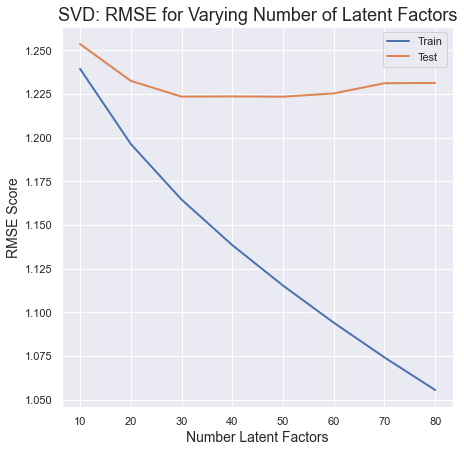

In [50]:
plot_rmse(svd_fact, svd_train_rmse, svd_test_rmse, "SVD")

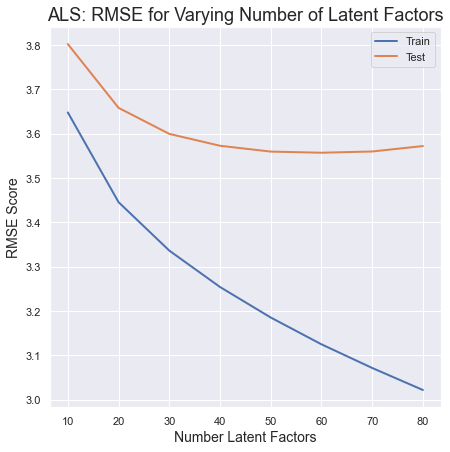

In [55]:
plot_rmse(als_fact, als_train_rmse, als_test_rmse, "ALS")

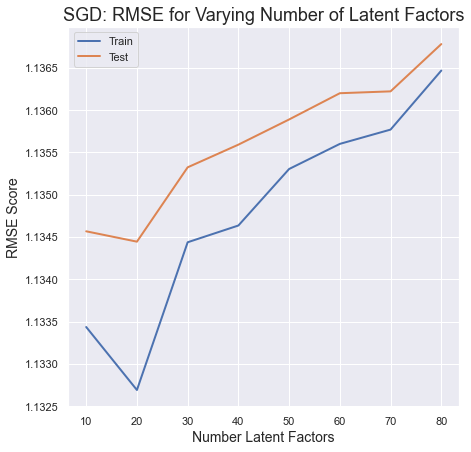

In [52]:
plot_rmse(sgd_fact, sgd_train_rmse, sgd_test_rmse, "SGD")

### Learning Curve: RMSE vs. Number of Iterations

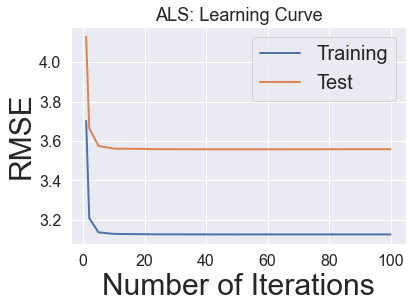

In [21]:
iter_array = [1, 2, 5, 10, 25, 50, 100]
plot_learning_curve(iter_array, best_als_model, 'ALS')

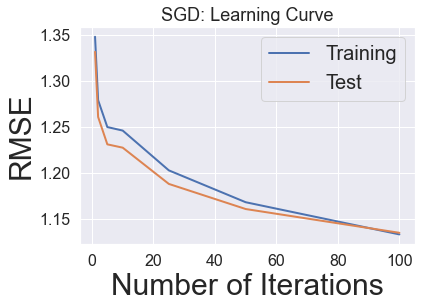

In [22]:
iter_array = [1, 2, 5, 10, 25, 50, 100]
plot_learning_curve(iter_array, best_sgd_model, 'SGD')

# Get Recommendations

## Relevant Functions

In [23]:
def cosine_similarity(model):
    sim = model.item_vecs.dot(model.item_vecs.T)
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T

In [24]:
def display_top_n_animes(similarity, mapper, input_anime_idx, method, n=10):
    anime_indices = np.argsort(similarity[input_anime_idx,:])[::-1]
    j=1
    ranked_list = []

    while j < n+1:
        anime = mapper[anime_indices[j]]
        ranked_list.append([j, anime])
        j += 1
    # Display Dataframe with anime recs
    title_chosen = mapper[anime_indices[0]]
    ranked_df = pd.DataFrame(ranked_list, columns=['Rank', 'Anime Title'])
    ranked_df= ranked_df.style.set_caption("Recommendations for '{}' using {}".format(title_chosen, method))
    return ranked_df

In [25]:
# Get Indices to Animes
anime_titles = user_anime_ratings_matrix.columns
anime_titles_list = list(anime_titles)
anime_indices = {}
animes_to_idx = {}
for i in range(len(anime_titles_list)):
    anime_indices[i] = anime_titles_list[i]
    animes_to_idx[anime_titles_list[i]] = i

## Rebuild Each Model with Best Parameters

In [33]:
best_svd_model = ExplicitMF(inputMatrix, n_factors=50, learning='SVD', item_fact_reg=0.1, user_fact_reg=0.1, user_bias_reg=0.1, item_bias_reg=0.1)
best_svd_model.train(1)


In [34]:
best_als_model = ExplicitMF(inputMatrix, n_factors=60, learning='ALS', item_fact_reg=0.1, user_fact_reg=0.1, user_bias_reg=0.1, item_bias_reg=0.1)
best_als_model.train(50, learning_rate=0.001)

In [35]:
best_sgd_model = ExplicitMF(inputMatrix, n_factors=20, learning='SGD', item_fact_reg=0.1, user_fact_reg=0.1, user_bias_reg=0.1, item_bias_reg=0.1)
best_sgd_model.train(100, learning_rate=0.001)

## Calculate Cosine Similarity

In [29]:
svd_sim = cosine_similarity(best_svd_model)
als_sim = cosine_similarity(best_als_model)
sgd_sim = cosine_similarity(best_sgd_model)

## Get Recommendations

In [30]:
# SVD - Top Ten Recommendations
title_chosen = "One Punch Man"
idx_chosen = animes_to_idx[title_chosen]
recommendations_df = display_top_n_animes(svd_sim, anime_indices, idx_chosen, 'SVD')
recommendations_df

,Rank,Anime Title
0,1,One Piece: Umi no Heso no Daibouken-hen
1,2,One Piece Movie 4: Dead End no Bouken
2,3,One Piece Movie 5: Norowareta Seiken
3,4,Oni Chichi: Re-birth
4,5,One Punch Man Specials
5,6,One Piece: Straw Hat Theater
6,7,Ookiku Furikabutte
7,8,One Piece: Heart of Gold
8,9,One Piece: Glorious Island
9,10,One Piece: Yume no Soccer Ou!


In [31]:
# ALS - Top Ten Recommendations
title_chosen = "One Punch Man"
idx_chosen = animes_to_idx[title_chosen]
recommendations_df = display_top_n_animes(als_sim, anime_indices, idx_chosen, 'ALS')
recommendations_df

,Rank,Anime Title
0,1,Boku no Hero Academia
1,2,Shingeki no Kyojin
2,3,Re:Zero kara Hajimeru Isekai Seikatsu
3,4,Overlord
4,5,No Game No Life
5,6,Kono Subarashii Sekai ni Shukufuku wo!
6,7,Nanatsu no Taizai
7,8,Boku dake ga Inai Machi
8,9,Shokugeki no Souma
9,10,Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka


In [32]:
# SGD - Top Ten Recommendations
title_chosen = "One Punch Man"
idx_chosen = animes_to_idx[title_chosen]
recommendations_df = display_top_n_animes(sgd_sim, anime_indices, idx_chosen, 'SGD')
recommendations_df

,Rank,Anime Title
0,1,Nanatsu no Taizai
1,2,One Punch Man: Road to Hero
2,3,Mob Psycho 100
3,4,No Game No Life
4,5,Boku no Hero Academia
5,6,One Punch Man Specials
6,7,Boku no Hero Academia 2nd Season
7,8,Katanagatari
8,9,Bakemono no Ko
9,10,One Piece Film: Gold
